# Human Face Detection using Pre-trained Model
Below are steps for facial detection of an image using YOLOv8. Since EDA is already performed in the traditional approach, its not repeated here.

## Downloading Images

Needed libararies are imported. Images are downloaded from Kaggle

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import shutil
import cv2
import random
import matplotlib.pyplot as plt
import copy

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sundarsundaresan47
Your Kaggle Key: ··········


100%|██████████| 498M/498M [00:04<00:00, 111MB/s]


In [5]:
os.listdir()

['.config', 'human-faces-object-detection', 'sample_data']

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Create Train, Validation, Test Datasets

define variables as needed. Split image dataset for training, validation and testing

In [7]:
bs=' ' # blank-space
class_id=0 # id for face
newline='\n' # new line character
extension='.txt' # extension for text file

In [8]:
# Creating paths for separate images and labels
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

In [9]:
# Defining data path and labels_path
data_path='/content/human-faces-object-detection'
labels_path = os.path.join(curr_path, 'face_labels')

In [10]:
# Creating labels path
os.makedirs(labels_path)

In [11]:
# Checking input data contents
os.listdir(data_path)

['faces.csv', 'images']

In [12]:
# Defining input images and raw annotations path
img_path=os.path.join(data_path, 'images')
raw_annotations_path=os.path.join(data_path, 'faces.csv')

In [13]:
# Creating a list of all images
face_list=os.listdir(img_path)

In [14]:
data_len=len(face_list)
data_len

2204

In [15]:
random.shuffle(face_list)
# Checking if they are shuffled
face_list[:5]

['00001732.jpg',
 '00001047.jpg',
 '00002722.jpg',
 '00001778.jpg',
 '00002154.jpg']

In [16]:
train_split=0.8
val_split=0.1
test_split=0.1

In [17]:
imgtrain_list=face_list[:int(data_len*train_split)]
imgval_list=face_list[int(data_len*train_split):int(data_len*(train_split+val_split))]
imgtest_list=face_list[int(data_len*(train_split+val_split)):]

In [18]:
# Checking the size of train, validation and test dataset
len(imgtrain_list), len(imgval_list), len(imgtest_list)

(1763, 220, 221)

YOLOv8 requires text file for every image. The text file should have the same name as the image file, only the image extension should be replaced by text extension. This text file contains the bounding box information of the objects in the corresponding image¶

In [19]:
# function to extract basename from a file and add a different extension to it.
def change_extension(file):
    basename=os.path.splitext(file)[0]
    filename=basename+extension
    return filename

In [20]:
labeltrain_list = list(map(change_extension, imgtrain_list))
labelval_list = list(map(change_extension, imgval_list))
labeltest_list = list(map(change_extension, imgtest_list))

In [21]:
# Checking if the list of text files are created correctly
len(labeltrain_list), len(labelval_list), len(labeltest_list)

(1763, 220, 221)

In [22]:
raw_annotations=pd.read_csv(raw_annotations_path)
raw_annotations

image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]

The raw annotations contain the diagonal points of the bounding box. YOLOv8 expects the bounding box information in the form of centre coordinates, width and height of the bounding box. So let's transform the information in the required format.¶

In [23]:
raw_annotations['x_centre']=0.5*(raw_annotations['x0']+raw_annotations['x1'])
raw_annotations['y_centre']=0.5*(raw_annotations['y0']+raw_annotations['y1'])
raw_annotations['bb_width']=raw_annotations['x1']-raw_annotations['x0']
raw_annotations['bb_height']=raw_annotations['y1']-raw_annotations['y0']
raw_annotations

image_name  width  height   x0   y0    x1   y1  x_centre  y_centre  \
0     00001722.jpg   1333    2000  490  320   687  664     588.5     492.0   
1     00001044.jpg   2000    1333  791  119  1200  436     995.5     277.5   
2     00001050.jpg    667    1000  304  155   407  331     355.5     243.0   
3     00001736.jpg    626     417  147   14   519  303     333.0     158.5   
4     00003121.jpg    626     418  462   60   599  166     530.5     113.0   
...            ...    ...     ...  ...  ...   ...  ...       ...       ...   
3345  00002232.jpg    620     349    4   36   186  158      95.0      97.0   
3346  00002232.jpg    620     349  122  103   344  248     233.0     175.5   
3347  00002232.jpg    620     349  258  118   541  303     399.5     210.5   
3348  00002232.jpg    620     349  215   11   362  108     288.5      59.5   
3349  00002232.jpg    620     349  330    1   487   81     408.5      41.0   

      bb_width  bb_height  
0          197        344  
1          409        317  
2          103        176  
3          372        289  
4          137        106  
...        ...        ...  
3345       182        122  
3346       222        145  
3347       283        185  
3348       147         97  
3349       157         80  

[3350 rows x 11 columns]

In [24]:
raw_annotations['xcentre_scaled']=raw_annotations['x_centre']/raw_annotations['width']
raw_annotations['ycentre_scaled']=raw_annotations['y_centre']/raw_annotations['height']
raw_annotations['width_scaled']=raw_annotations['bb_width']/raw_annotations['width']
raw_annotations['height_scaled']=raw_annotations['bb_height']/raw_annotations['height']
raw_annotations

image_name  width  height   x0   y0    x1   y1  x_centre  y_centre  \
0     00001722.jpg   1333    2000  490  320   687  664     588.5     492.0   
1     00001044.jpg   2000    1333  791  119  1200  436     995.5     277.5   
2     00001050.jpg    667    1000  304  155   407  331     355.5     243.0   
3     00001736.jpg    626     417  147   14   519  303     333.0     158.5   
4     00003121.jpg    626     418  462   60   599  166     530.5     113.0   
...            ...    ...     ...  ...  ...   ...  ...       ...       ...   
3345  00002232.jpg    620     349    4   36   186  158      95.0      97.0   
3346  00002232.jpg    620     349  122  103   344  248     233.0     175.5   
3347  00002232.jpg    620     349  258  118   541  303     399.5     210.5   
3348  00002232.jpg    620     349  215   11   362  108     288.5      59.5   
3349  00002232.jpg    620     349  330    1   487   81     408.5      41.0   

      bb_width  bb_height  xcentre_scaled  ycentre_scaled  width_scaled  \
0          197        344        0.441485        0.246000      0.147787   
1          409        317        0.497750        0.208177      0.204500   
2          103        176        0.532984        0.243000      0.154423   
3          372        289        0.531949        0.380096      0.594249   
4          137        106        0.847444        0.270335      0.218850   
...        ...        ...             ...             ...           ...   
3345       182        122        0.153226        0.277937      0.293548   
3346       222        145        0.375806        0.502865      0.358065   
3347       283        185        0.644355        0.603152      0.456452   
3348       147         97        0.465323        0.170487      0.237097   
3349       157         80        0.658871        0.117479      0.253226   

      height_scaled  
0          0.172000  
1          0.237809  
2          0.176000  
3          0.693046  
4          0.253589  
...             ...  
3345       0.349570  
3346       0.415473  
3347       0.530086  
3348       0.277937  
3349       0.229226  

[3350 rows x 15 columns]

In [25]:
len(raw_annotations['image_name'].unique())

2204

## Label files creation
Creating a text file for every image with the bounding box information in correct format. The correct format for each bounding box is as follows:
class_id   x_centre   y_centre   width   height
This is for every single bounding box. So, if there are multiple objects to detect in one image, there will be as many lines

In [26]:
# Getting all unique images
imgs=raw_annotations.groupby('image_name')

In [27]:
for image in imgs:
    img_df=imgs.get_group(image[0])
    basename=os.path.splitext(image[0])[0]
    txt_file=basename+extension
    filepath=os.path.join(labels_path, txt_file)
    lines=[]
    i=1
    for index,row in img_df.iterrows():
        if i!=len(img_df):
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+str(row['height_scaled'])+newline
            lines.append(line)
        else:
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+ str(row['height_scaled'])
            lines.append(line)
        i=i+1
    with open(filepath, 'w') as file:
        file.writelines(lines)

In [28]:
# Checking the labels directory
os.listdir(labels_path)[:5]

['00003065.txt',
 '00000005.txt',
 '00002919.txt',
 '00003054.txt',
 '00003309.txt']

In [29]:
random_file=os.path.join(labels_path, os.listdir(labels_path)[4])
with open (random_file, 'r') as f:
    content=f.read()
content

'0 0.7066993464052288 0.3799019607843137 0.2173202614379085 0.25\n0 0.3562091503267974 0.3174019607843137 0.3660130718954248 0.4338235294117647'

In [30]:
def_size=640 # Image size for YOLOv8

In [31]:
len(os.listdir(labels_path)) # Verifying all labels are created

2204

In [32]:
# function to move files from source to detination
def move_files(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        shutil.move(filepath, dest_path)
        i=i+1
    print("Number of files transferred:", i)

In [33]:
# function to resize the images and copy the resized image to destination
def move_images(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)

        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        finalimage_path=os.path.join(dest_path, file)
        img_resized=cv2.resize(cv2.imread(filepath), (def_size, def_size))
        cv2.imwrite(finalimage_path, img_resized)
        i=i+1
    print("Number of files transferred:", i)

In [34]:
move_images(imgtrain_list, img_path, imgtrainpath)

Number of files transferred: 1763


In [35]:
move_images(imgval_list, img_path, imgvalpath)

Number of files transferred: 220


In [36]:
move_images(imgtest_list, img_path, imgtestpath)

Number of files transferred: 221


Moving labels from source to train, validation and test directories¶

In [37]:
move_files(labeltrain_list, labels_path, labeltrainpath)

Number of files transferred: 1763


In [38]:
move_files(labelval_list, labels_path, labelvalpath)

Number of files transferred: 220


In [39]:
move_files(labeltest_list, labels_path, labeltestpath)

Number of files transferred: 221


Check if all the label files are moved

In [40]:
len(os.listdir(labels_path))

0

In [41]:
shutil.rmtree(labels_path) # removing labels path as it is empty

## Creating config file
Below is the format of config file for YOLOv8
train: images/train # train images
val: images/val # val images
test: # test images (optional)

names:
0: person
1: bicycle
2: car
...
77: teddy bear
78: hair drier
79: toothbrush

In [42]:
ln_1='# Train/val/test sets'+newline
ln_2='train: ' +"'"+imgtrainpath+"'"+newline
ln_3='val: ' +"'" + imgvalpath+"'"+newline
ln_4='test: ' +"'" + imgtestpath+"'"+newline
ln_5=newline
ln_6='# Classes'+newline
ln_7='names:'+newline
ln_8='  0: face'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8]

In [43]:
# Creating path for config file
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'/content/config.yaml'

In [44]:
# Writing config file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

## Image Visualisation
Let's write a function to obtain bounding box coordinates from text label files.

In [45]:
# function to obtain bounding box  coordinates from text label files
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    with open(text_file_path, "r") as file:
        for line in file:
            _,x_centre,y_centre,width,height=line.strip().split(" ")
            x1=(float(x_centre)+(float(width)/2))*def_size
            x0=(float(x_centre)-(float(width)/2))*def_size
            y1=(float(y_centre)+(float(height)/2))*def_size
            y0=(float(y_centre)-(float(height)/2))*def_size

            vertices=np.array([[int(x0), int(y0)], [int(x1), int(y0)],
                               [int(x1),int(y1)], [int(x0),int(y1)]])
#             vertices=vertices.reshape((-1,1,2))
            bbox_list.append(vertices)

    return tuple(bbox_list)

Drawing bouding box around faces in some randomly selected images in training dataset using training labels

In [46]:
# defining red color in RGB to draw bounding box
red=(255,0,0)

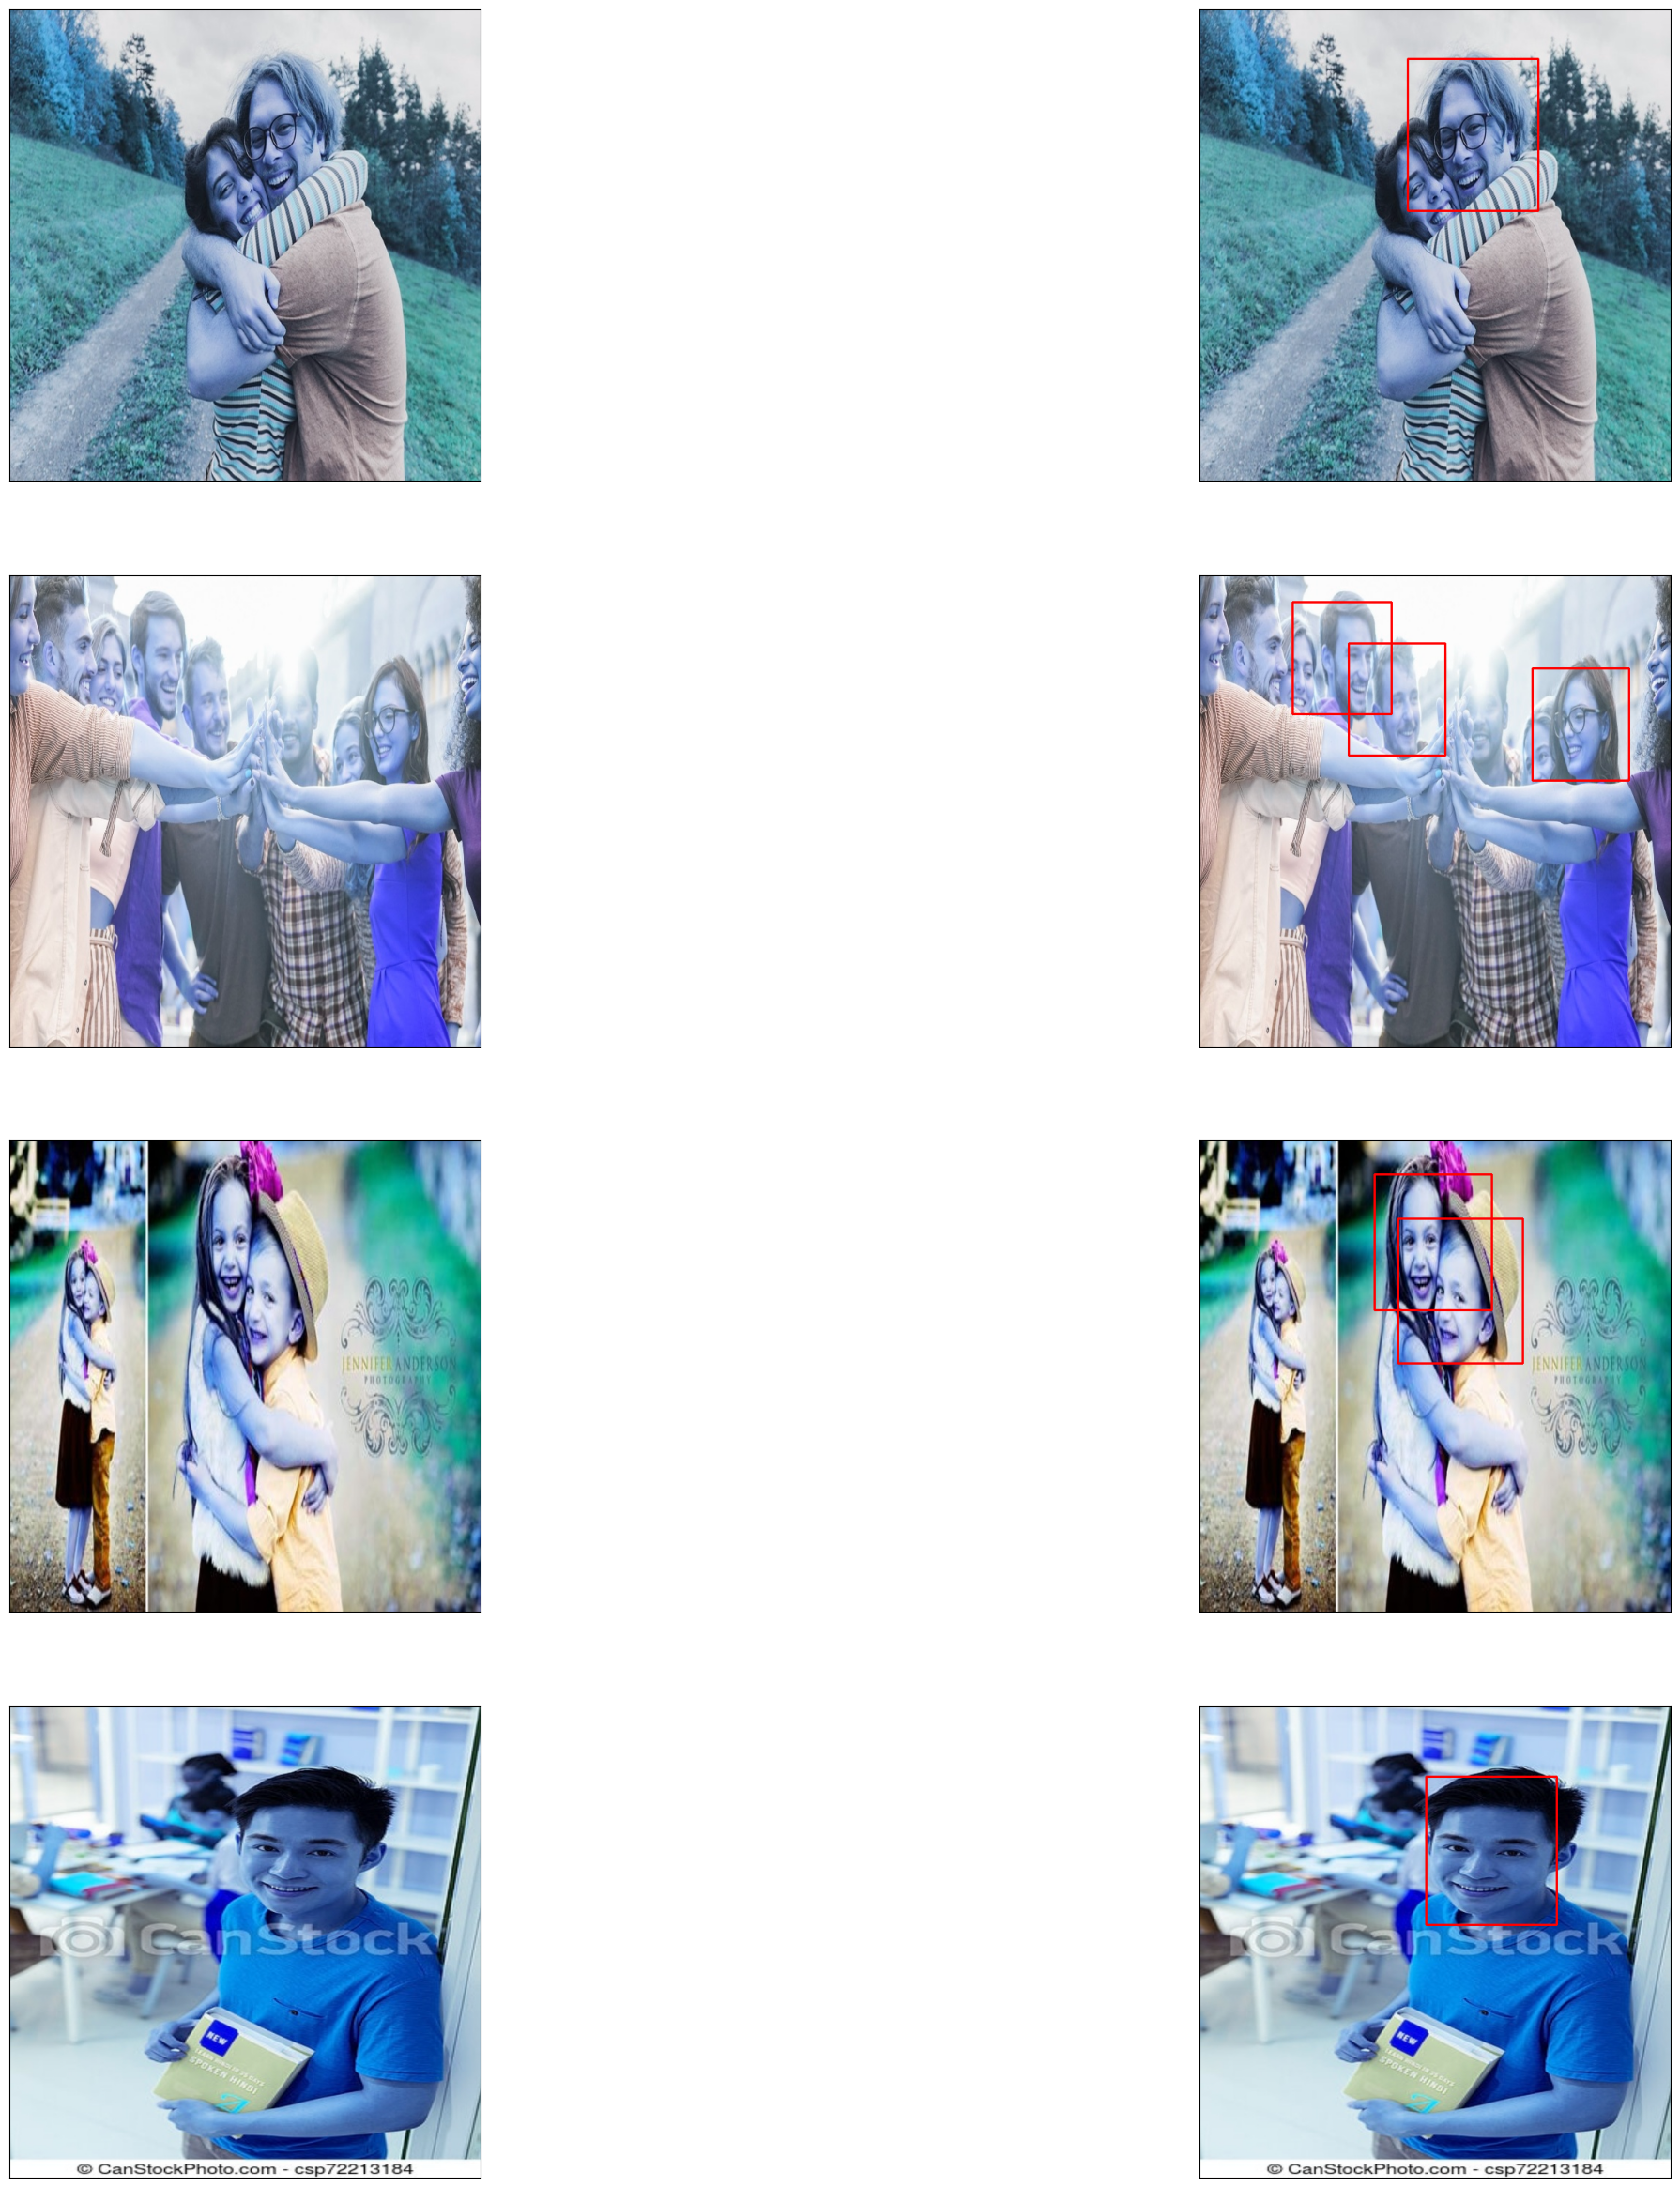

In [47]:
plt.figure(figsize=(30,30))
for i in range(1,8,2):
    k=random.randint(0, len(imgtrain_list)-1)
    img_path=os.path.join(imgtrainpath, imgtrain_list[k])
    label_path=os.path.join(labeltrainpath, labeltrain_list[k])
    bbox=get_bbox_from_label(label_path)
    image=cv2.imread(img_path)
    image_copy=copy.deepcopy(image)
    ax=plt.subplot(4, 2, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, red, 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 2, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

These images validate the created text file labels and show that we are good to go for training

## Model Training & Optimization
Let's install ultralytics and use YOLOv8 to detect faces¶

In [48]:
# Installing ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.4/660.4 kB 6.5 MB/s eta 0:00:00


In [49]:
from ultralytics import YOLO

In [50]:
# Using YOLO's ptetrained model architecture and weights for training
model=YOLO('yolov8n.yaml').load('yolov8n.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 112MB/s]

Transferred 355/355 items from pretrained weights


In [51]:
# Training the model
results=model.train(data=config_path, epochs=100, resume=True, iou=0.5, conf=0.001)

Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscri

100%|██████████| 755k/755k [00:00<00:00, 22.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/labels/train... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:01<00:00, 1461.59it/s]


train: New cache created: /content/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/labels/validation... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<00:00, 1353.74it/s]

val: New cache created: /content/labels/validation.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.33G      1.517       2.06        1.6         10        640: 100%|██████████| 111/111 [00:19<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        220        339      0.833      0.825      0.873      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.3G      1.384      1.463      1.501         12        640: 100%|██████████| 111/111 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


                   all        220        339      0.786      0.844      0.801      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.35G      1.345      1.255      1.462          9        640: 100%|██████████| 111/111 [00:15<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        220        339      0.772      0.838      0.794      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.31G       1.35      1.117      1.478          8        640: 100%|██████████| 111/111 [00:15<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        220        339      0.816      0.786      0.871      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.29G      1.283      1.026      1.434          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        220        339      0.843      0.915      0.921      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.29G      1.225     0.9687      1.392         10        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]

                   all        220        339      0.825      0.947      0.931      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.3G       1.22     0.9332      1.383         13        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]

                   all        220        339      0.845      0.879      0.901      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.3G      1.192     0.8971      1.364          8        640: 100%|██████████| 111/111 [00:15<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.12it/s]

                   all        220        339      0.803      0.973      0.874      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.29G      1.184     0.9021      1.373          9        640: 100%|██████████| 111/111 [00:15<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.856      0.908      0.943      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.31G      1.146     0.8576      1.328          7        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        220        339      0.839      0.947      0.928      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.34G      1.129     0.8584      1.334          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        220        339       0.88      0.929      0.961      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.29G      1.103     0.8248      1.302         10        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        220        339      0.843      0.947      0.947       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.29G      1.089      0.805      1.299          7        640: 100%|██████████| 111/111 [00:15<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

                   all        220        339      0.842      0.957      0.937      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.29G      1.097     0.8075       1.31          9        640: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.856      0.971      0.961      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.31G      1.073     0.7804      1.288          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.897      0.935       0.96      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.32G      1.041     0.7725      1.272         10        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        220        339      0.882      0.938      0.962      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.32G      1.031     0.7407      1.272         11        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        220        339      0.887      0.924      0.941      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.31G      1.043      0.763      1.265         13        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]

                   all        220        339      0.843      0.965      0.944       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.31G      1.047     0.7547      1.277          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        220        339       0.87      0.946       0.96      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.31G      1.012     0.7367      1.243          3        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        220        339      0.836      0.982      0.959      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.29G     0.9943      0.712      1.234          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        220        339      0.862      0.941      0.938       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.28G     0.9822     0.7269      1.235          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        220        339      0.906      0.938       0.97      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.3G     0.9959     0.7224      1.241          9        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        220        339      0.897      0.932      0.966      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.31G      0.957     0.6945      1.217          9        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        220        339      0.885      0.933      0.969      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.29G     0.9631     0.7079      1.223          5        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        220        339       0.87      0.968      0.951      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.29G     0.9508     0.6851      1.214         15        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        220        339      0.884       0.94      0.961      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.34G     0.9446     0.6809      1.199          3        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.13it/s]

                   all        220        339      0.903      0.947      0.956      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.31G     0.9438     0.6827      1.212          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        220        339      0.902      0.941       0.97      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.31G     0.9349      0.683      1.212          9        640: 100%|██████████| 111/111 [00:15<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all        220        339      0.869      0.953      0.951      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.28G     0.9209     0.6687      1.199         16        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

                   all        220        339      0.886       0.95      0.962      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.34G     0.9282     0.6743      1.201         13        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]

                   all        220        339      0.871      0.953      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.32G     0.9193     0.6551      1.191          4        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all        220        339      0.909      0.917      0.959      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.3G     0.9055     0.6576      1.187         11        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        220        339      0.878      0.955       0.97      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.29G      0.911      0.661       1.19          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.873      0.956      0.962      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.34G     0.9194     0.6558      1.196          9        640: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        220        339      0.909      0.946      0.972      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.32G     0.8938     0.6497      1.179          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all        220        339      0.905      0.917      0.968      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.31G     0.8993      0.633      1.187          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        220        339      0.882      0.947      0.963       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.3G     0.8903     0.6463      1.177          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]

                   all        220        339      0.888      0.958       0.96      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.29G     0.8707     0.6209       1.16          5        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        220        339      0.898      0.944      0.961       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.3G     0.8628     0.6167      1.156         10        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        220        339      0.896      0.914      0.962      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.31G     0.8569     0.6086      1.149          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

                   all        220        339      0.891      0.942      0.968      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.3G     0.8556     0.6041      1.155          7        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        220        339      0.867      0.968      0.974      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.34G     0.8542     0.6175      1.145         12        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        220        339      0.868      0.968       0.96      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.32G     0.8612     0.6117      1.143          8        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        220        339      0.907      0.956       0.97      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.29G     0.8496     0.6106      1.155          5        640: 100%|██████████| 111/111 [00:16<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]

                   all        220        339      0.883      0.954      0.965      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.31G     0.8316     0.5947      1.141         12        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]

                   all        220        339      0.914      0.937       0.97      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.3G     0.8415     0.5923      1.146         15        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all        220        339      0.888      0.965      0.963      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.31G     0.8397     0.5909      1.148          9        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        220        339      0.908      0.932      0.972      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.31G     0.8352     0.5976       1.15          6        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        220        339      0.874      0.962      0.971      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.32G     0.8352     0.5859      1.143          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all        220        339      0.887      0.947      0.963      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.29G     0.8323     0.5855      1.132         10        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        220        339      0.896      0.945      0.972      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.33G     0.7998     0.5602      1.119          9        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]

                   all        220        339      0.884      0.966      0.975      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.3G     0.8112     0.5655      1.118         13        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all        220        339      0.894      0.956      0.958      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.3G     0.8154     0.5863      1.131         10        640: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all        220        339      0.893      0.956      0.971      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.34G     0.7831      0.551      1.115          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        220        339      0.917      0.929      0.975      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.29G     0.8001     0.5612      1.127          4        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.12it/s]

                   all        220        339      0.868      0.938      0.943      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.3G     0.7857     0.5637      1.102         10        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.899      0.917      0.959      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.3G     0.7823     0.5467      1.107         12        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        220        339      0.869      0.965      0.968      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.29G     0.7995      0.555      1.115          4        640: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        220        339      0.906      0.929      0.961      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.29G     0.7926     0.5554      1.117          5        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


                   all        220        339      0.915      0.923      0.962      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.3G      0.765      0.544      1.094         10        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        220        339      0.924      0.926       0.97      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.28G      0.781     0.5512      1.102          4        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.897      0.947      0.969      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.31G     0.7636     0.5365      1.103          4        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        220        339      0.882      0.948      0.964      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.32G     0.7613     0.5387      1.094         13        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.15it/s]

                   all        220        339      0.906      0.939      0.964      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.34G     0.7654      0.538      1.101          6        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]

                   all        220        339      0.904       0.94      0.962      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.29G     0.7635     0.5395      1.094          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        220        339      0.891      0.938       0.96      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.29G      0.758     0.5284      1.096          4        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all        220        339      0.869      0.971      0.963      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.32G     0.7406     0.5205       1.08          6        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all        220        339      0.857      0.971      0.955       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.33G      0.733     0.5166      1.081          5        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.13it/s]

                   all        220        339      0.869      0.962      0.962      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.3G     0.7503     0.5269       1.09          4        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        220        339      0.902      0.956      0.973      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.32G     0.7346     0.5135      1.079          5        640: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        220        339      0.872       0.95       0.96      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.31G     0.7259      0.511       1.08          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

                   all        220        339      0.913      0.934      0.971      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.31G     0.7457     0.5325      1.084          5        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        220        339      0.896       0.95       0.96      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.3G      0.713     0.4856      1.057         12        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        220        339      0.894      0.938      0.959      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.31G      0.725     0.5086      1.079         12        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        220        339      0.873      0.956      0.973      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.3G     0.7237     0.5039      1.068          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all        220        339      0.919       0.92      0.967      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.29G     0.7063     0.4981      1.061          3        640: 100%|██████████| 111/111 [00:15<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        220        339      0.926      0.918      0.966      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.3G     0.7105     0.4907      1.061          6        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]

                   all        220        339       0.92      0.914      0.953       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.31G     0.7266     0.5106       1.08          4        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        220        339      0.889      0.944      0.966        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.32G     0.7111     0.4972       1.07          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

                   all        220        339      0.898      0.933      0.961      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.29G     0.6992     0.4857      1.053          4        640: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]

                   all        220        339      0.909      0.947      0.963      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.28G     0.7006     0.4859       1.06          7        640: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all        220        339      0.918      0.932      0.956      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.3G     0.6913     0.4843      1.046          8        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        220        339      0.912      0.923      0.963      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.32G     0.6893     0.4711      1.049         12        640: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

                   all        220        339      0.901      0.941      0.959      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.3G     0.6909     0.4742      1.054         12        640: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]

                   all        220        339      0.891      0.944      0.948      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.29G     0.6798     0.4644       1.05         11        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.909      0.932      0.952      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.31G     0.6811     0.4791       1.05         15        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        220        339      0.896      0.936      0.953      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.29G     0.6667     0.4633      1.037         16        640: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        220        339      0.886      0.943      0.958      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.34G     0.6704     0.4666      1.039          9        640: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        220        339       0.91      0.935      0.949      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.3G       0.68     0.4803      1.053          9        640: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

                   all        220        339      0.898       0.93       0.95      0.791


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.3G     0.5305     0.3151     0.9496         13        640: 100%|██████████| 111/111 [00:16<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        220        339      0.899      0.943      0.954      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.31G     0.5224     0.3023     0.9486          4        640: 100%|██████████| 111/111 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        220        339      0.923      0.917      0.956      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.29G     0.5155     0.2935     0.9408          3        640: 100%|██████████| 111/111 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        220        339      0.908      0.934      0.953      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.28G     0.5147     0.2988     0.9358          3        640: 100%|██████████| 111/111 [00:15<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all        220        339      0.924      0.923      0.953      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.29G     0.5042      0.298     0.9305          3        640: 100%|██████████| 111/111 [00:15<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        220        339      0.944        0.9      0.962      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.29G     0.5022     0.2954     0.9357          4        640: 100%|██████████| 111/111 [00:15<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        220        339      0.896      0.953      0.963      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.29G     0.4913     0.2885      0.926          3        640: 100%|██████████| 111/111 [00:15<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]

                   all        220        339      0.887      0.954      0.958      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.28G     0.4885     0.2854     0.9276          4        640: 100%|██████████| 111/111 [00:15<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        220        339      0.926      0.918      0.956      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.29G     0.4816      0.275     0.9206          6        640: 100%|██████████| 111/111 [00:15<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

                   all        220        339      0.897      0.947      0.957      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.31G     0.4788     0.2821      0.919          3        640: 100%|██████████| 111/111 [00:15<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]

                   all        220        339        0.9      0.944      0.957      0.801



100 epochs completed in 0.494 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        220        339      0.896      0.953      0.963      0.814
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


In [52]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [53]:
!zip -r results.zip /content/runs/detect/train

  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/val_batch1_labels.jpg (deflated 11%)
  adding: content/runs/detect/train/val_batch2_pred.jpg (deflated 7%)
  adding: content/runs/detect/train/train_batch9990.jpg (deflated 10%)
  adding: content/runs/detect/train/results.png (deflated 8%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 3%)
  adding: content/runs/detect/train/args.yaml (deflated 52%)
  adding: content/runs/detect/train/P_curve.png (deflated 22%)
  adding: content/runs/detect/train/train_batch9991.jpg (deflated 9%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 7%)
  adding: content/runs/detect/train/val_batch0_pred.jpg (deflated 7%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/best.pt (deflated 10%)
  adding: content/runs/detect/train/weights/last.pt (deflated 10%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 38%)
  adding:

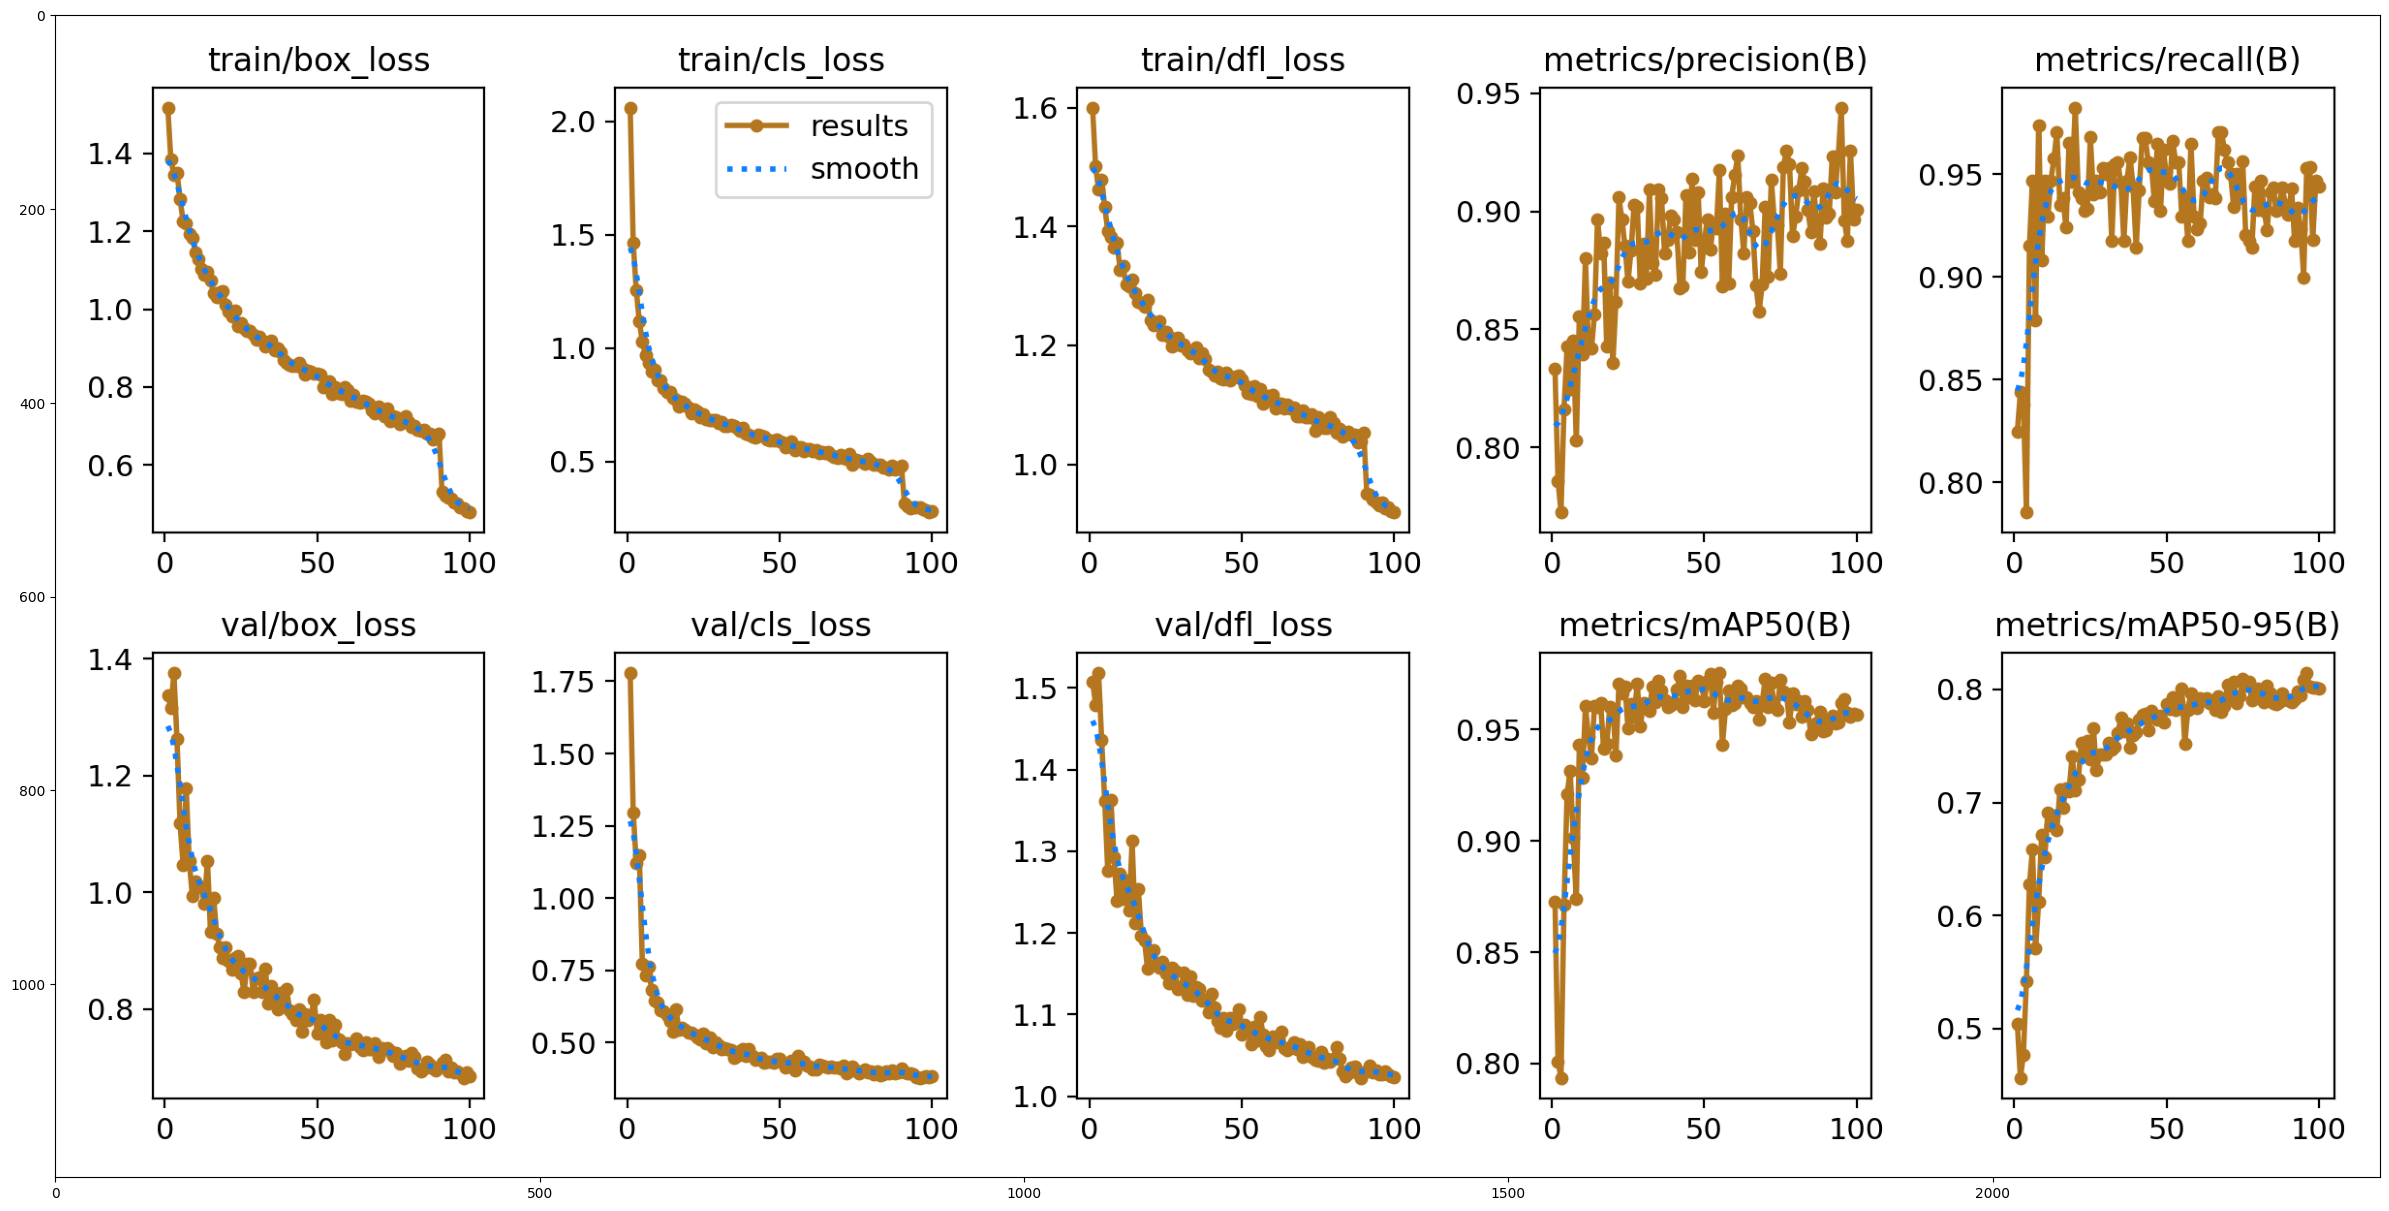

In [54]:
plt.figure(figsize=(30,30))
trainingresult_path=os.path.join(curr_path, 'runs', 'detect', 'train')
results_png=cv2.imread(os.path.join(trainingresult_path,'results.png'))
plt.imshow(results_png)

All losses- Box loss, class loss, dfl loss are decreasing with epochs.
All metrics- Precision, Recall, mAP50 and mAP50-95 are increasing with epochs

## Model Performance

In [55]:
# function for evaluating model metrics map50
def evaluate_map50(trainedmodel, data_path, dataset='val'):
    metrics=trainedmodel.val(data=data_path, split=dataset)
    map50=round(metrics.box.map50, 3)
    print("The mAP of model on {0} dataset is {1}".format(dataset,map50))
    return metrics, map50

In [56]:
# function for displaying plots created by YOLO
def display_curves(root_path):
    plt.figure(figsize=(50,50))

    #displaying p curve
    p_curve=cv2.imread(os.path.join(root_path,'P_curve.png'))
    ax=plt.subplot(5,1,1)
    plt.imshow(p_curve)

    #displaying r curve
    r_curve=cv2.imread(os.path.join(root_path,'R_curve.png'))
    ax=plt.subplot(5,1,2)
    plt.imshow(r_curve)

    #displaying pr curve
    pr_curve=cv2.imread(os.path.join(root_path,'PR_curve.png'))
    ax=plt.subplot(5,1,3)
    plt.imshow(pr_curve)

    #displaying f1 curve
    f1_curve=cv2.imread(os.path.join(root_path,'F1_curve.png'))
    ax=plt.subplot(5,1,4)
    plt.imshow(f1_curve)

    #displaying confusion matrix
    confusion_matrix=cv2.imread(os.path.join(root_path,'confusion_matrix.png'))
    ax=plt.subplot(5,1,5)
    plt.imshow(confusion_matrix)

In [57]:
# Evaluating train metrics
train_metrics, train_map50=evaluate_map50(model, config_path, dataset='train')

Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/labels/train.cache... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:16<00:00,  6.60it/s]


                   all       1763       2643      0.976      0.984      0.993       0.91
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2
The mAP of model on train dataset is 0.993


In [58]:
train_path=os.path.join(curr_path, 'runs', 'detect', 'train2') #val is a misnomer, it is actually measuring validation on training dataset

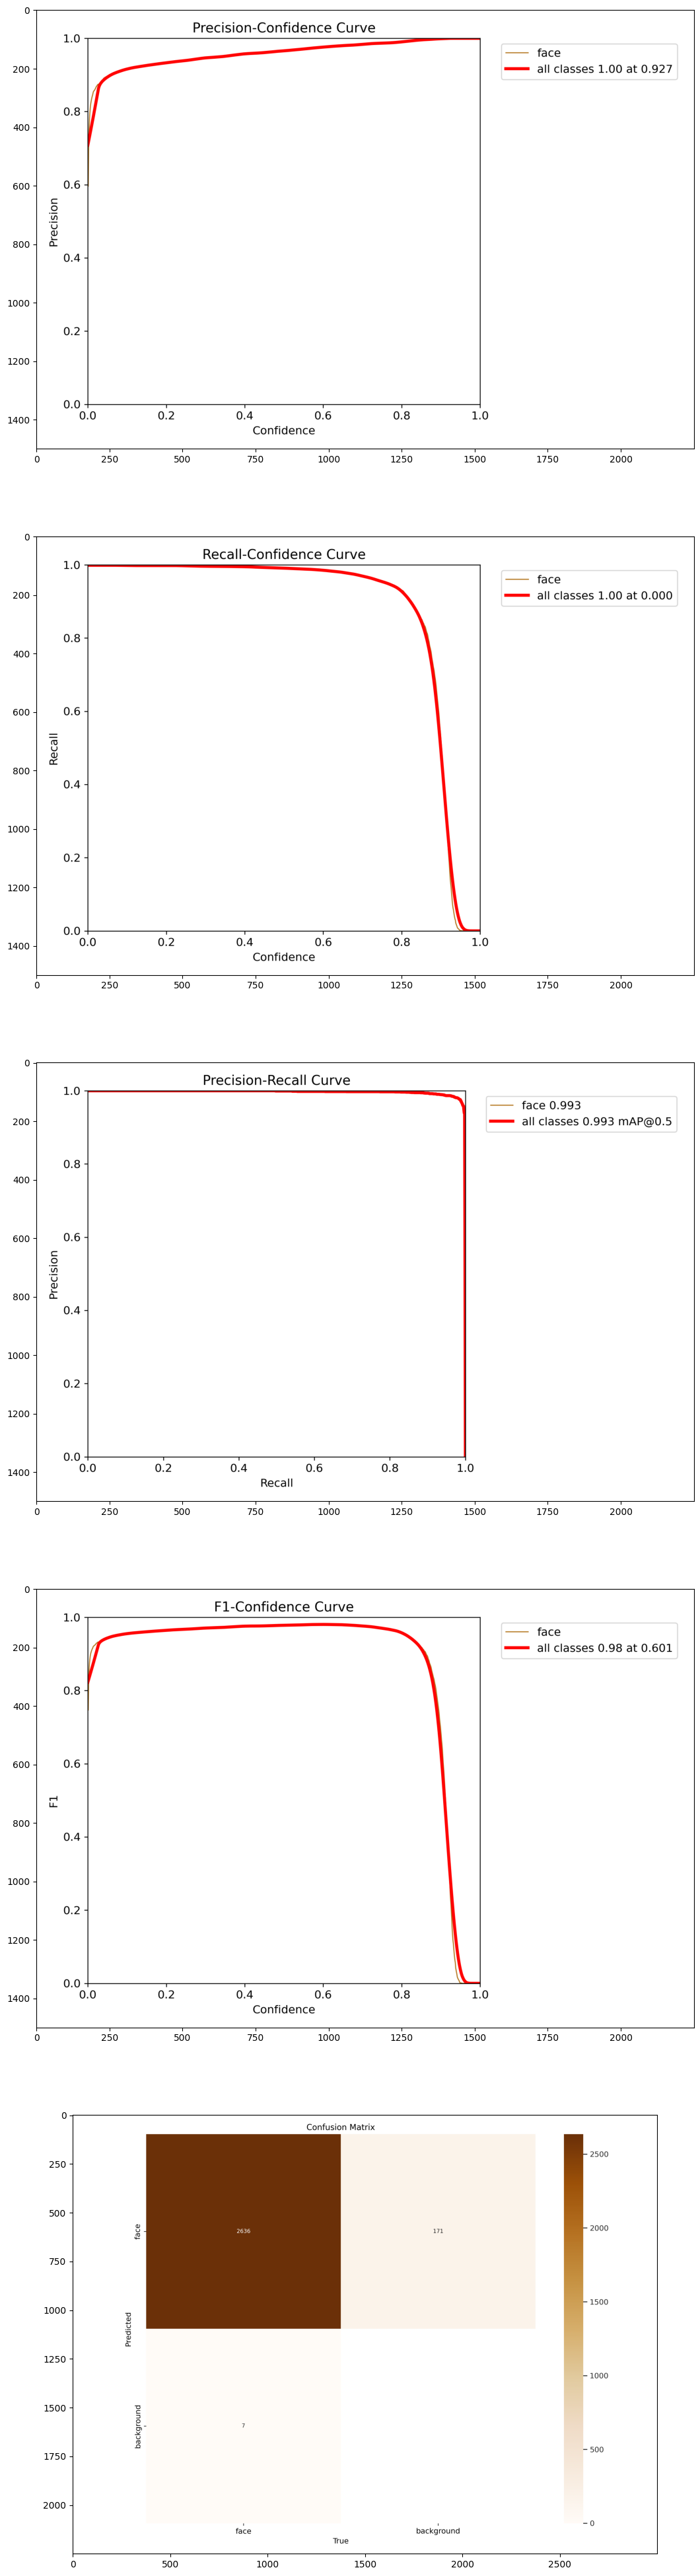

In [59]:
# Display plots on training data
display_curves(train_path)

In [60]:
# Evaluating val metrics
val_metrics, val_map50=evaluate_map50(model, config_path, dataset='val')

Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/labels/validation.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.91it/s]


                   all        220        339      0.896      0.953      0.963      0.813
Speed: 0.7ms preprocess, 7.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train3
The mAP of model on val dataset is 0.963


In [63]:
val_path=os.path.join(curr_path, 'runs', 'detect', 'train3')

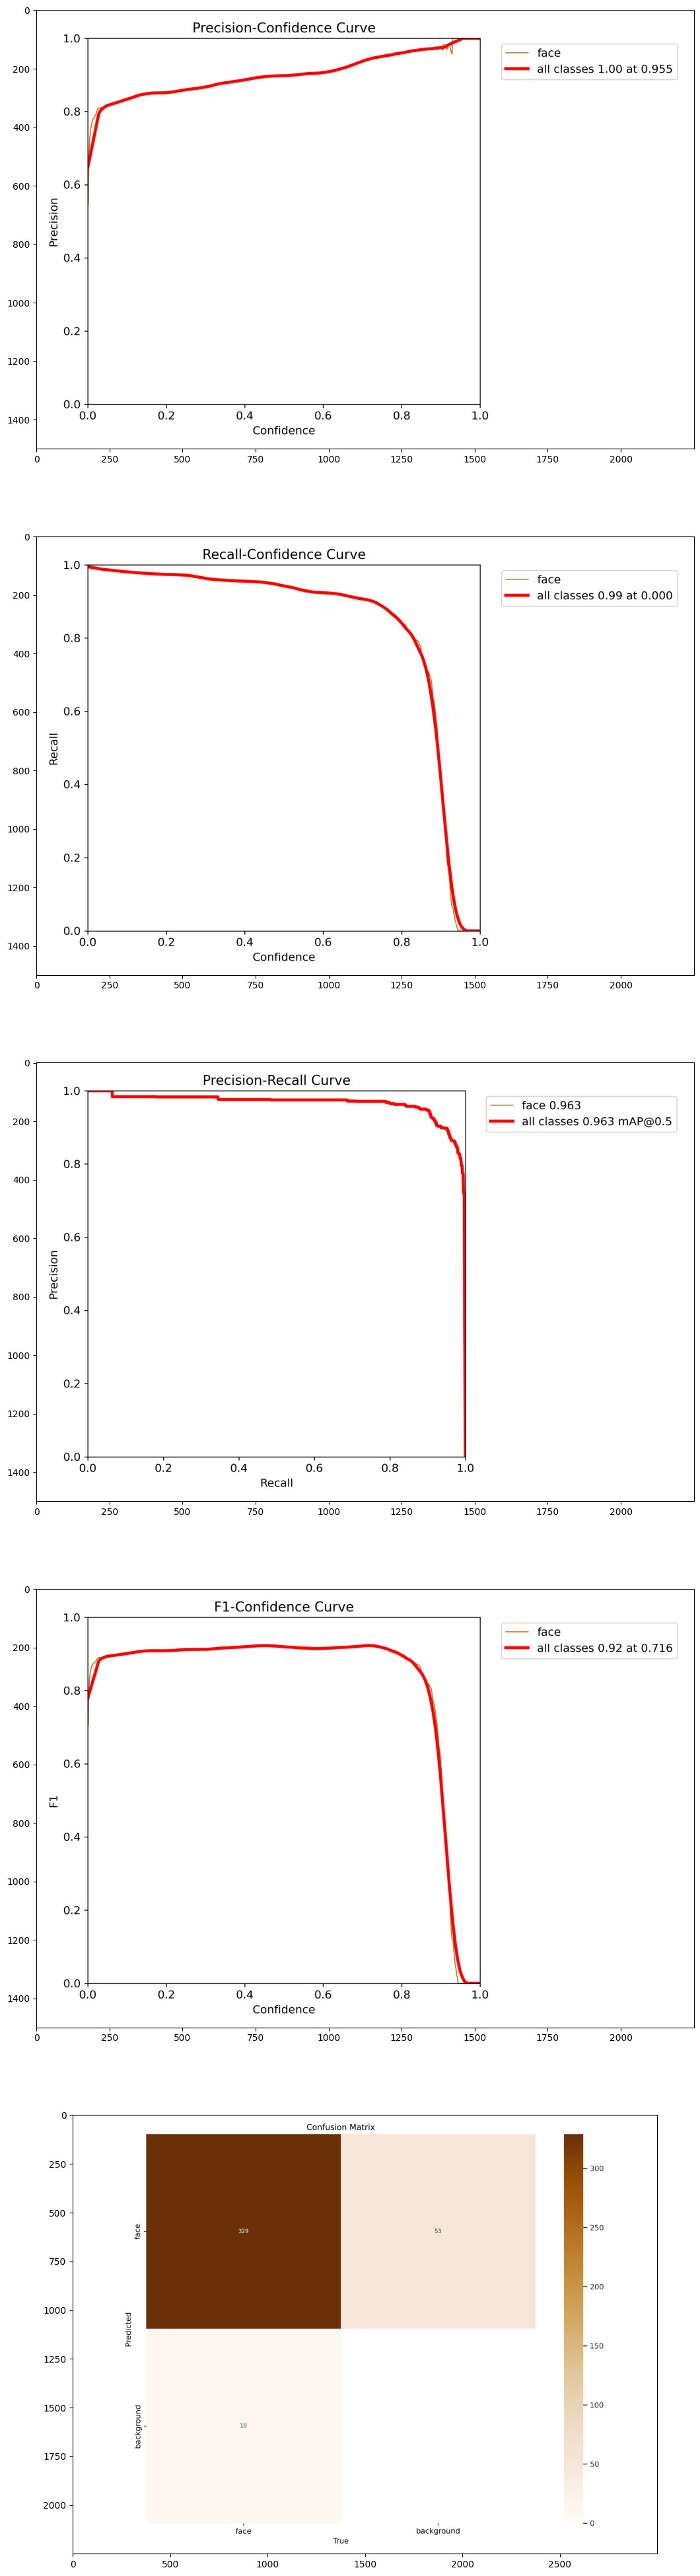

In [64]:
# Display plots on validation data
display_curves(val_path)

In [65]:
# Evaluating test metrics
test_metrics, test_map50=evaluate_map50(model, config_path, dataset='test')

Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/labels/test... 221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 221/221 [00:00<00:00, 1387.45it/s]

val: New cache created: /content/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.84it/s]


                   all        221        368      0.924      0.978      0.979      0.833
Speed: 0.3ms preprocess, 8.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train4
The mAP of model on test dataset is 0.979


In [66]:
test_path=os.path.join(curr_path, 'runs', 'detect', 'train4')

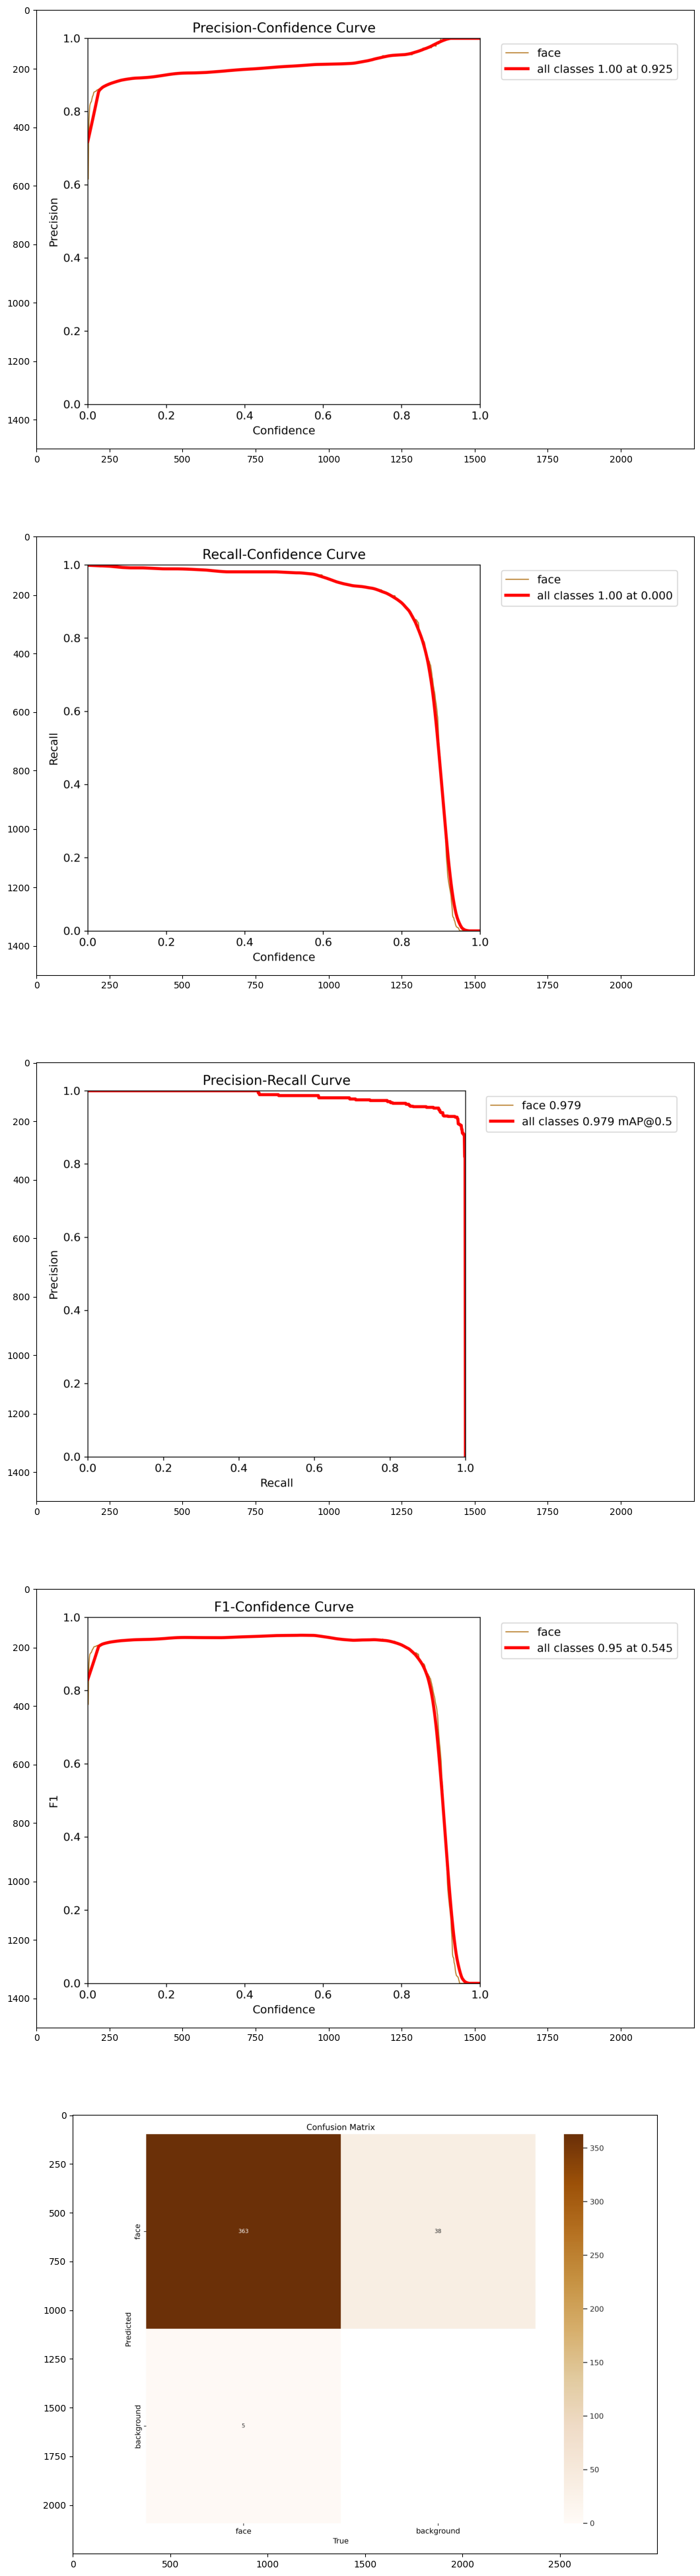

In [67]:
# Display plots on test data
display_curves(test_path)

## Visualizing model's performance on random test images


image 1/1 /content/images/test/00001067.jpg: 640x640 1 face, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00003104.jpg: 640x640 1 face, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00001532.jpg: 640x640 1 face, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00003256.jpg: 640x640 1 face, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


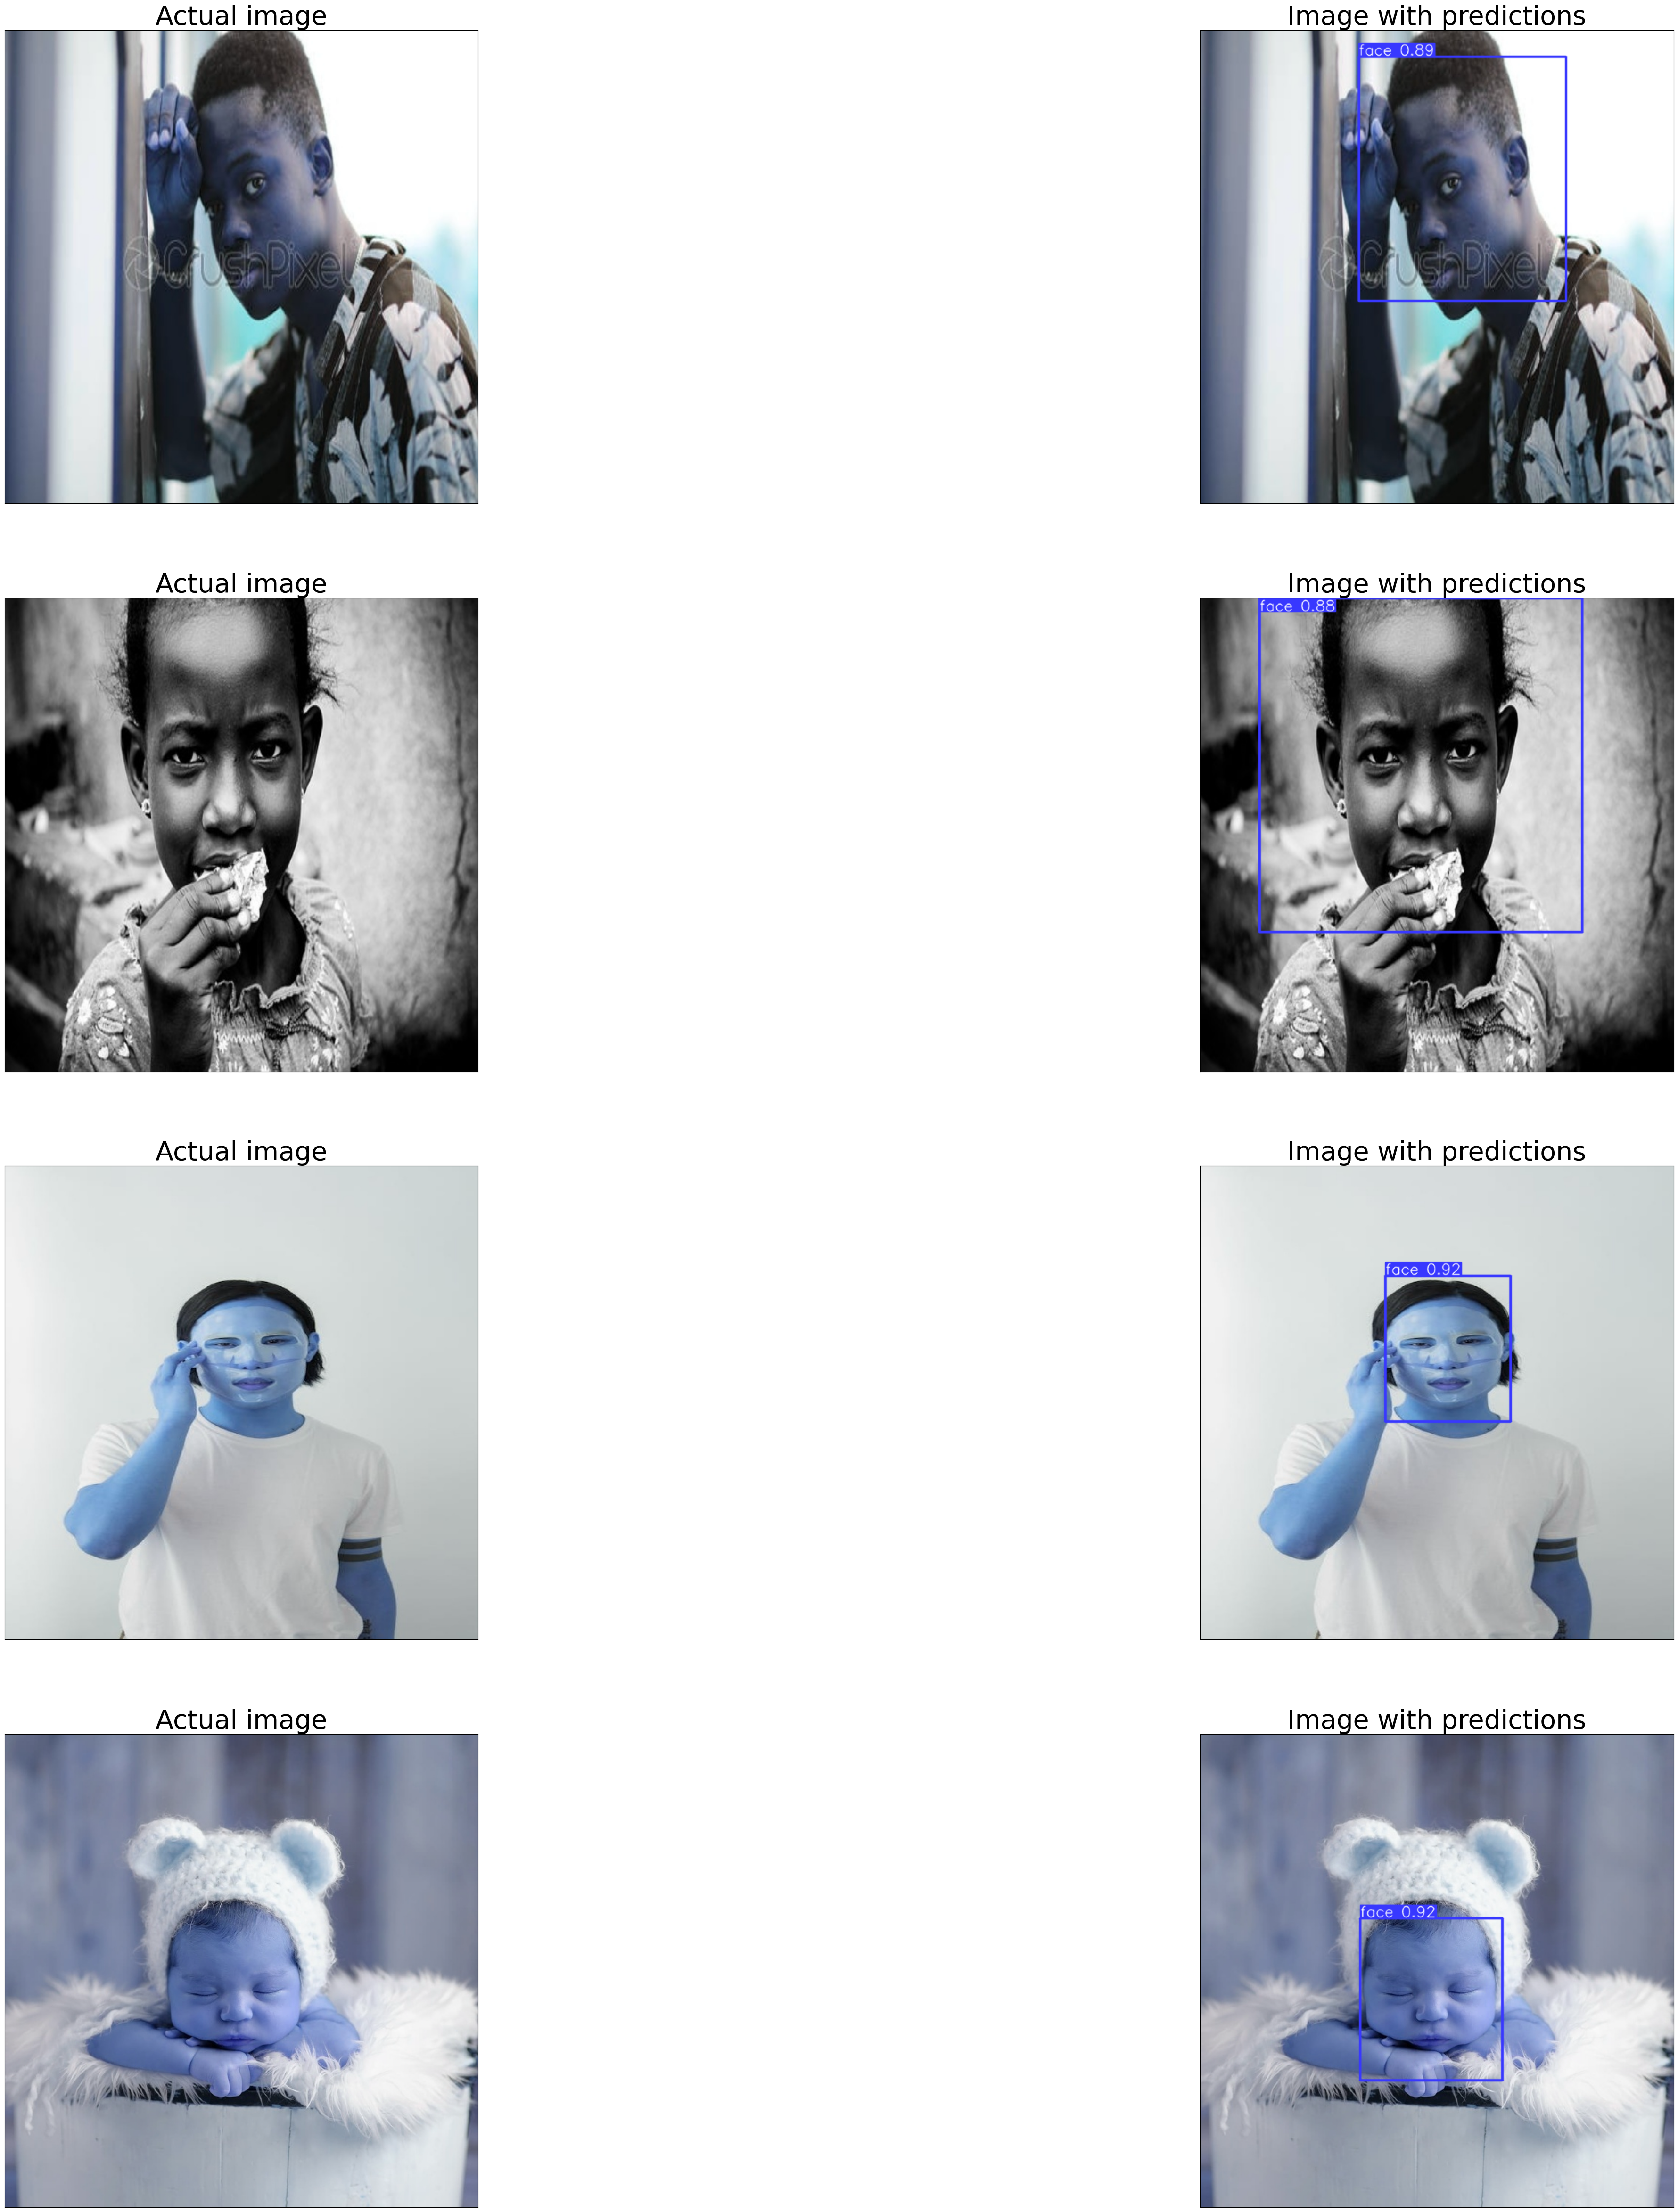

In [68]:
plt.figure(figsize=(60,60))
m=random.randint(0, 150) # Selecting random image number
for i in range(1,8,2):
    test_image=os.path.join(imgtestpath, os.listdir(imgtestpath)[m])
    ax=plt.subplot(4,2,i)

    # Display actual image
    plt.imshow(cv2.imread(test_image))
    plt.xticks([])
    plt.yticks([])
    plt.title("Actual image", fontsize = 40)

    # Predict
    res = model(test_image)
    res_plotted = res[0].plot()
    ax=plt.subplot(4,2,i+1)

    # Display image with predictions
    plt.imshow(res_plotted)
    plt.title("Image with predictions", fontsize = 40)
    plt.xticks([])
    plt.yticks([])
    m=m+1

In [ ]:
plt.figure(figsize=(60,60))
testImage=os.path.join(imgtestpath, "customImage1.jpeg")
plt.imshow(cv2.imread(testImage))
plt.xticks([])
plt.yticks([])
plt.title("Actual image", fontsize = 40)

# Predict
res = model(testImage)
res_plotted = res[0].plot()
ax=plt.subplot(4,2,i+1)

# Display image with predictions
plt.imshow(res_plotted)
plt.title("Image with predictions", fontsize = 40)
plt.xticks([])
plt.yticks([])
